# Can figure out substrate uptake hierarchy without running the whole simulation

# Match individual growth rates first
# Using coarse model

## Ways to use gradient information
- correlation between Z and params_i
- confidence interval of dzdx (its sign)

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['svg.fonttype'] = 'none'
pd.set_option('display.max_colwidth', -1)
%matplotlib inline

In [2]:
PROTOTYPE = False

In [3]:
from dynamicme.tests.helpme import HelpME
from dynamicme.dynamic import get_cplx_concs

helper = HelpME(prototyping=PROTOTYPE)
solver = helper.solver
me = solver.me

## Change keffs until uptake hierarchy correct

In [4]:
import numpy as np

df_dh = pd.read_csv('/home/laurence/ME/data/DHeckmann/kappmax_rf_dl_iJO.csv')

import re
from cobra.io import load_json_model

ijo = load_json_model('/home/laurence/ME/models/BiGG_M/json/iJO1366.json')

rows = []
biggids = df_dh['bigg.id'].apply(lambda x: re.sub(r'(_[b|f]$)', '',x)).unique()
missed = []
for biggid in biggids:
    try:
        sdata = me.stoichiometric_data.get_by_id(biggid)
        mrxn = ijo.reactions.get_by_id(biggid)
        rname = mrxn.name        
        for rxn in sdata.parent_reactions:
            mmol_gDW = rxn.x / rxn.keff / 3600
            rows.append({'bigg_id':biggid, 'rxn':rxn.id, 'name':rname, 'keff_nominal':rxn.keff, 'subsystem':mrxn.subsystem, 'reaction':mrxn.reaction, 'mmol_gDW':mmol_gDW})
    except KeyError:
        missed.append(biggid)
        
df_rmap = pd.DataFrame(rows)
        
print 'biggids not mapped:', len(missed)

biggids not mapped: 252


In [5]:
print 'Subsystems:', len(df_rmap.subsystem.unique())
print 'Rxns within alternate carbon metab:', len(df_rmap.rxn[ df_rmap.subsystem=='Alternate Carbon Metabolism'])

ProtM = df_rmap.mmol_gDW.sum()
print 'Expressed protein (mmol/gDW):', ProtM

Subsystems: 35
Rxns within alternate carbon metab: 285
Expressed protein (mmol/gDW): 0.00495155284852


In [6]:
%%time

KEFF_SCALE = 0.32

from cobra import Metabolite, Reaction

ijomc = load_json_model('/home/laurence/ME/models/BiGG_M/json/iJO1366.json')

cons_crowding = Metabolite('crowding')
ijomc.add_metabolites([cons_crowding])

# sum_j v/keff  <= P [mmol/gDW]

for rid in df_rmap.bigg_id.unique():    
    dfi = df_rmap[ df_rmap.bigg_id==rid]
    keff_nom = dfi['keff_nominal'].mean()
    rxn = ijomc.reactions.get_by_id(rid)
    if rxn.lower_bound < 0:
        rxn_abs = Reaction(rxn.id + '_abs')
        ijomc.add_reaction(rxn_abs)
        # rabs >= r  :  rabs - r >= 0
        # rabs >= -r :  rabs + r >= 0        
        cons_abs_p = Metabolite('cons_'+rxn.id+'_abs_p')
        cons_abs_n = Metabolite('cons_'+rxn.id+'_abs_n')
        cons_abs_p._constraint_sense = 'G'
        cons_abs_n._constraint_sense = 'G'
        rxn_abs.add_metabolites({cons_abs_p: 1., cons_abs_n: 1.})
        rxn.add_metabolites({cons_abs_p:-1., cons_abs_n:1.})
        keff = keff_nom * KEFF_SCALE
        rxn_abs.add_metabolites({cons_crowding:1./keff/3600 })
    else:
        rxn.add_metabolites({cons_crowding:1./keff_nom/3600})

cons_crowding._constraint_sense = 'L'
cons_crowding._bound = ProtM

CPU times: user 1.63 s, sys: 0 ns, total: 1.63 s
Wall time: 1.63 s


In [7]:
ijomc.optimize(solver='gurobi')

<Solution 0.74 at 0x7f828b5afed0>

In [8]:
df_meas = pd.read_csv('/home/laurence/ME/data/dynamicME/beg/growth_meas.csv')

In [9]:
rank_meas = {'EX_ac_e': 5,
             'EX_gal_e': 2,
             'EX_glc__D_e': 0,
             'EX_glyc_e': 4,
             'EX_lac__L_e': 1,
             'EX_malt_e': 3
            }    

In [10]:
%%time

mrows = []
ZERO = 1e-8

for ex_id in rank_meas.keys():
    # Reset first
    for rid in rank_meas.keys():
        rxn = ijomc.reactions.get_by_id(rid)
        rxn.lower_bound = 0.
    rxn = ijomc.reactions.get_by_id(ex_id)
    rxn.lower_bound = -10
    ijomc.optimize()
    mmu = ijomc.reactions.BIOMASS_Ec_iJO1366_core_53p95M.x
    # Was the MC constraint active?
    tot_prot = sum([r.x*r.metabolites[cons_crowding] for r in cons_crowding.reactions])
    mrows.append({'muopt':mmu, 'ex_rxn':ex_id, 'tot_prot':tot_prot, 'crowding_active':abs(cons_crowding._bound - tot_prot)<ZERO})

CPU times: user 5.24 s, sys: 0 ns, total: 5.24 s
Wall time: 5.24 s


In [11]:
df_ijo = pd.DataFrame(mrows)

Pearson r=0.936904 (p=0.00584603)
Spearman r=0.942857 (p=0.00480466)


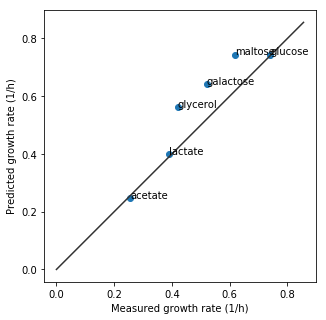

In [12]:
import scipy.stats as stats

df_val = pd.merge(df_ijo, df_meas, on='ex_rxn')
xymax = max(df_val.growth_rate_1_h.max(), df_val.muopt.max())
plt.plot([0, xymax*1.15], [0, xymax*1.15], color='#333333')
plt.scatter(df_val.growth_rate_1_h, df_val.muopt)
for i,r in df_val.iterrows():
    x = r['growth_rate_1_h']
    y = r['muopt']
    k = r['substrate']
    ls = plt.text(x, y, k)
ax = ls.axes
ax.set_aspect(1)
ax.figure.set_size_inches(5,5)
ax.set_xlabel('Measured growth rate (1/h)')
ax.set_ylabel('Predicted growth rate (1/h)')

r,p = stats.pearsonr(df_val.growth_rate_1_h, df_val.muopt)
print 'Pearson r=%g (p=%g)' % (r,p)
r,p = stats.spearmanr(df_val.growth_rate_1_h, df_val.muopt)
print 'Spearman r=%g (p=%g)' % (r,p)

# Metaheuristics on small model to get growth rates right

In [13]:
df_exp = df_meas[ df_meas.ex_rxn.isin(rank_meas.keys())]
meas_dict = {r['ex_rxn']:r['growth_rate_1_h'] for i,r in df_exp.iterrows()}

In [14]:
def sim_fun(mdl):
    mu_id = 'BIOMASS_Ec_iJO1366_core_53p95M'
    sim_dict = {}
    for ex_id in meas_dict.keys():
        # Reset first
        for rid in meas_dict.keys():
            rxn = mdl.reactions.get_by_id(rid)
            rxn.lower_bound = 0.
        rxn = mdl.reactions.get_by_id(ex_id)
        rxn.lower_bound = -10
        mdl.optimize(solver='gurobi')
        try:
            mmu = mdl.reactions.get_by_id(mu_id).x
        except Exception:
            mmu = 0.
        sim_dict[ex_id] = mmu
    
    return sim_dict

In [15]:
def obj_fun(y_sim, y_meas):
    ### Objective function    
    sse = sum([ (y - y_sim[r])**2 for r,y in y_meas.iteritems()]) 
    
    return sse

In [16]:
def get_param_fun(mdl):
    cons_id = 'crowding'
    cons = mdl.metabolites.get_by_id(cons_id)
    params = [r.metabolites[cons] for r in cons.reactions]
    
    return params

def set_param_fun(mdl, xs):
    cons_id = 'crowding'
    cons = mdl.metabolites.get_by_id(cons_id)
    for j,rxn in enumerate(cons.reactions):
        rxn._metabolites[cons] = xs[j]

In [17]:
y0 = sim_fun(ijomc)
obj_fun(y0, meas_dict)

0.05053794765568237

In [18]:
import copy as cp

mdl2 = cp.deepcopy(ijomc)

In [ ]:
from dynamicme.metaopt import MetaOpt

In [ ]:
%%time

for k in range(1000):
    mopt = MetaOpt(mdl2, sim_fun, obj_fun, get_param_fun, set_param_fun)
    result = mopt.optimize(meas_dict, max_iter_phase1=50, param_confidence=0.99, use_gradient=False, verbosity=0)#, max_iter_phase2=1000, max_reject=500)# , max_iter_phase1=50, max_reject=50, verbosity=0)
    set_param_fun(mdl2, result[2])

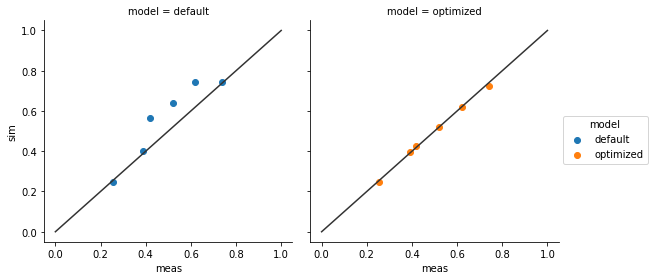

In [27]:
ex_ids = meas_dict.keys()
y_sim0 = sim_fun(ijomc)
y_best = result[0]
df0 = pd.DataFrame([{'rxn':k, 'meas':meas_dict[k], 'sim':y_sim0[k], 'model':'default'} for k in ex_ids])
df1 = pd.DataFrame([{'rxn':k, 'meas':meas_dict[k], 'sim':y_best[k], 'model':'optimized'} for k in ex_ids])
df_val = pd.concat([df0, df1])

g = sns.FacetGrid(df_val, hue='model', size=4, col='model')
g.map(plt.scatter, 'meas', 'sim')
g.add_legend()
ax = g.axes.flatten()[0]
for ax in g.axes.flat:
    ax.plot([0,1], [0,1], color='#333333', zorder=1)

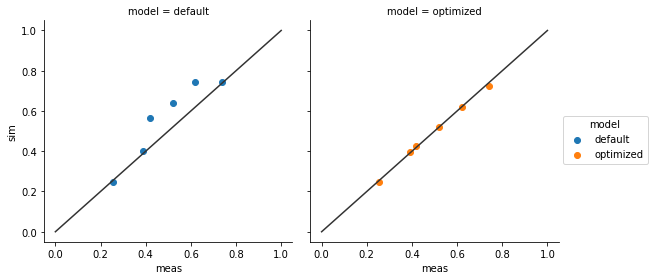

In [40]:
ex_ids = meas_dict.keys()
y_sim0 = sim_fun(ijomc)
mdl_fit = cp.deepcopy(ijomc)
set_param_fun(mdl_fit, result[2])
#y_best = result[0]
#y_best = sim_fun(mdl_fit)
k_best = get_param_fun(mdl2)
#y_best = sim_fun(mdl2)

df0 = pd.DataFrame([{'rxn':k, 'meas':meas_dict[k], 'sim':y_sim0[k], 'model':'default'} for k in ex_ids])
df1 = pd.DataFrame([{'rxn':k, 'meas':meas_dict[k], 'sim':y_best[k], 'model':'optimized'} for k in ex_ids])
df_val = pd.concat([df0, df1])

g = sns.FacetGrid(df_val, hue='model', size=4, col='model')
g.map(plt.scatter, 'meas', 'sim')
g.add_legend()
ax = g.axes.flatten()[0]
for ax in g.axes.flat:
    ax.plot([0,1], [0,1], color='#333333', zorder=1)

In [28]:
df_val.groupby('model').apply(lambda x: sum((x['meas']-x['sim'])**2)).reset_index()

,model,0
0,default,0.050538
1,optimized,0.000403


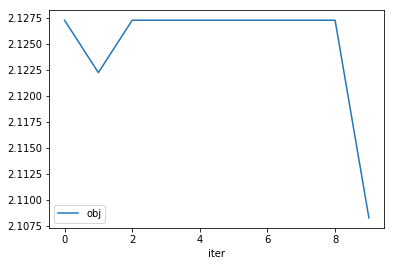

In [29]:
### Track LBTA history
df_lbta = pd.DataFrame([{'obj':d['obj'], 'iter':d['iter']} for d in result[1] if d['phase']==2])
df_lbta.plot('iter','obj')

In [30]:
df_val.groupby('model').apply(lambda x: sum((x['meas']-x['sim'])**2)).reset_index()

,model,0
0,default,0.050538
1,optimized,0.000403


import json
from cobra.io.json import save_json_model

keff_best = result[2]
#keff_best = get_param_fun(mdl2)
with open('/home/laurence/ME/data/dynamicME/keffs_ijo_best1000.json', 'w') as f:
    json.dump(keff_best, f)
with open('/home/laurence/ME/data/dynamicME/mus_ijo_best1000.json', 'w') as f:
    json.dump(result[0], f)
with open('/home/laurence/ME/data/dynamicME/hist_ijo_best1000.json', 'w') as f:
    json.dump(result[1], f)

save_json_model(mdl2, '/home/laurence/ME/data/dynamicME/best_ijomc.json')

In [35]:
from __future__ import division

g = mopt.stats['gradient'][0]
sum(g==0) / len(g)

0.99752229930624381

# Other methods
1. Evolutin strategies. suggested by ["Parameter Estimation in Biochemical Pathways: A Comparison of Global Optimization Methods"](http://genome.cshlp.org/content/13/11/2467.full)

# Using genetic algorithm

import random, math
import deap
import operator
from deap import creator, base, tools, algorithms, gp

def protectedDiv(left,right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1
    
pset = gp.PrimitiveSet('MAIN',1)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(operator.neg, 1)
pset.addPrimitive(math.cos, 1)
pset.addPrimitive(math.sin, 1)
pset.addEphemeralConstant('rand101', lambda: random.randint(-1,1))

creator.create('FitnessMin', base.Fitness, weights=(-1.,))
creator.create('Individual', gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register('expr', gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register('individual', tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register('population', tools.initRepeat, list, toolbox.individual)
toolbox.register('compile', gp.compile, pset=pset)

def fun_meas(x):
    #y = x**4 - x**3 - x**2 - x
    y = meas_dict[x]
    return y

def eval_fitness(individual, points):
    y_meas = [meas_dict[k] for k in points]
    # Update mdl
    sim_dict  = sim_fun(mdl)
    y_sim = [sim_dict[k] for k in points]
    sse = obj_fun(y_sim, y_meas)
    return sse, 

ex_rxnids = meas_dict.keys()

toolbox.register('evaluate', evalSymbReg, points=ex_rxnids)
toolbox.register('select', tools.selTournament, tournsize=3)
toolbox.register('mate', gp.cxOnePoint)
toolbox.register('expr_mut', gp.genFull, min_=0, max_=2)
toolbox.register('mutate', gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate('mate', gp.staticLimit(key=operator.attrgetter('height'), max_value=17))
toolbox.decorate('mutate', gp.staticLimit(key=operator.attrgetter('height'), max_value=17))

import numpy as np

stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register('avg', np.mean)
mstats.register('std', np.std)
mstats.register('min', np.min)
mstats.register('max', np.max)

pop = toolbox.population(n=300)
hof = tools.HallOfFame(1)
pop, log = algorithms.eaSimple(pop, toolbox, 0.5, 0.1, 40, stats=mstats, halloffame=hof, verbose=True)

print hof.items